In [1]:
!pip install nonconformist

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from nonconformist.cp import IcpClassifier
from nonconformist.nc import ClassifierNc

In [2]:
#Load the data
df = pd.read_csv('credit_scoring_dataset.csv')
X = df.drop('loan_status', axis=1)
y = df['loan_status']

In [3]:
#Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
#Create and fit the underlying model
underlying_model = RandomForestClassifier(random_state=42)
model = CalibratedClassifierCV(underlying_model, cv=5)

In [5]:
#Create the noncormity function
nc = ClassifierNc(model)

In [6]:
#Create the inductive conformal classifier
icp = IcpClassifier(nc)

In [7]:
df['income'] = np.clip(np.exp(df['income'] * 2), 0, 1e6) * 1000 + 20000
df['loan_amount'] = np.clip(np.exp(df['loan_amount']), 0, 1e6) * 1000 + 5000

X_train = np.clip(X_train, -1e10, 1e10)

C:\Users\matim\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
#Fit the ICP
icp.fit(X_train.values, y_train.values)
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [9]:
X_combined = np.vstack((X_train, X_test))
y_combined = np.concatenate((y_train, y_test))

In [10]:
# Replace inf with nan
X_combined = np.where(np.isinf(X_combined), np.nan, X_combined)

# Remove rows with nan
mask = ~np.isnan(X_combined).any(axis=1)
X_combined = X_combined[mask]
y_combined = y_combined[mask]

In [11]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_combined_scaled = scaler.fit_transform(X_combined)

In [15]:
# Before cleaning
print("Before cleaning:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Before cleaning:
X_train shape: (8000, 8)
X_test shape: (2000, 8)


In [19]:
from sklearn.impute import SimpleImputer

# Combine train and test data
X_combined = np.vstack((X_train, X_test))
y_combined = np.concatenate((y_train, y_test))

# Replace inf with nan
X_combined = np.where(np.isinf(X_combined), np.nan, X_combined)

# Impute nan values
imputer = SimpleImputer(strategy='mean')
X_combined_imputed = imputer.fit_transform(X_combined)

# Scale the data
scaler = RobustScaler()
X_combined_scaled = scaler.fit_transform(X_combined_imputed)

# Split back into train and test
n_train = X_train.shape[0]
X_train_cleaned = X_combined_scaled[:n_train]
X_test_cleaned = X_combined_scaled[n_train:]
y_train_cleaned = y_combined[:n_train]
y_test_cleaned = y_combined[n_train:]

print("\nAfter imputation and scaling:")
print(f"X_train_cleaned shape: {X_train_cleaned.shape}")
print(f"X_test_cleaned shape: {X_test_cleaned.shape}")


After imputation and scaling:
X_train_cleaned shape: (8000, 8)
X_test_cleaned shape: (2000, 8)


In [20]:
from nonconformist.base import ClassifierAdapter
from nonconformist.icp import IcpClassifier
from nonconformist.nc import ClassifierNc

# Wrapping the Random Forest model
model = ClassifierAdapter(underlying_model)
nc = ClassifierNc(model)
icp = IcpClassifier(nc)

In [21]:
#Fitting and Calibrating the ICP

icp.fit(X_train_cleaned, y_train_cleaned)
icp.calibrate(X_test_cleaned, y_test_cleaned)

In [22]:
#Make Predictions

try:
    predictions = icp.predict(X_test_cleaned, significance=0.5)
    print("Predictions shape:", predictions.shape)
except Exception as e:
    print("An error occurred:", str(e))

Predictions shape: (2000, 2)


In [23]:
#Print results
print("Predictions shape:", predictions.shape)
print("First few predictions:")
print(predictions[:5])

Predictions shape: (2000, 2)
First few predictions:
[[False False]
 [False False]
 [ True False]
 [False  True]
 [False  True]]


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from nonconformist.cp import IcpClassifier
from nonconformist.nc import ClassifierNc

In [25]:
# Load the dataset
df = pd.read_csv('credit_scoring_dataset.csv')


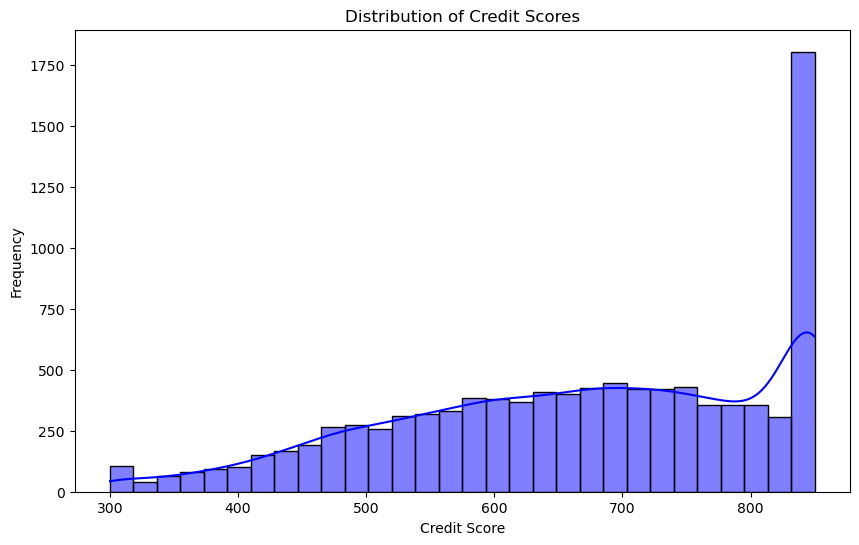

In [26]:
# Plot: Distribution of Credit Scores
plt.figure(figsize=(10, 6))
sns.histplot(df['credit_score'], kde=True, bins=30, color='blue')
plt.title('Distribution of Credit Scores')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.show()

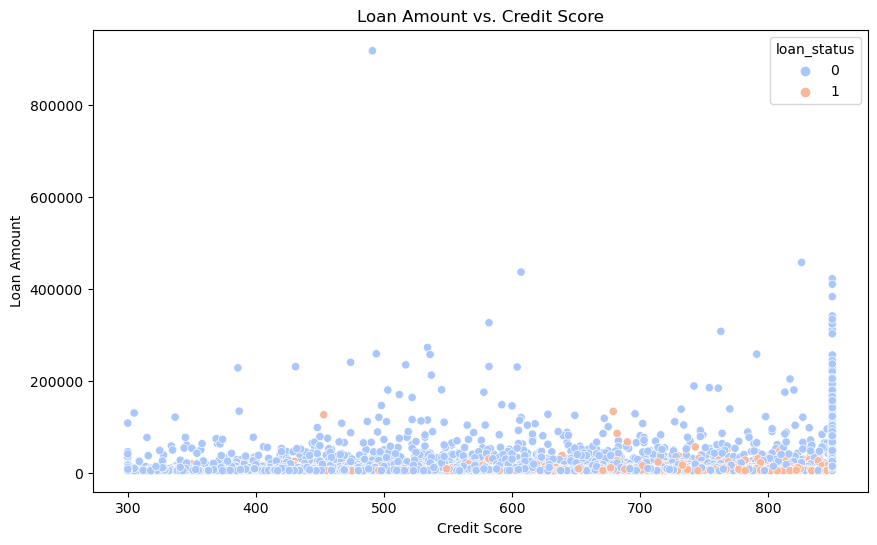

In [45]:
# Plot: Loan Amount vs. Credit Score
plt.figure(figsize=(10, 6))
sns.scatterplot(x='credit_score', y='loan_amount', hue='loan_status', data=df, palette='coolwarm')
plt.title('Loan Amount vs. Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Loan Amount')
plt.show()

In [27]:

X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

In [28]:
print(np.isfinite(X_train.values).all())
print(np.isfinite(X_test.values).all())

True
False


In [29]:
#Clipping Infinite values

X_train = np.clip(X_train, a_min=-1e10, a_max=1e10)
X_test = np.clip(X_test, a_min=-1e10, a_max=1e10)

In [30]:
print(X_train.max())
print(X_test.max())

income               1.000000e+10
age                  1.100654e+03
employment_length    1.900000e+01
debt_to_income       1.877551e+00
credit_score         8.500000e+02
num_credit_lines     2.500000e+01
num_late_payments    1.200000e+01
loan_amount          9.170458e+05
dtype: float64
income               1.000000e+10
age                  9.871169e+02
employment_length    1.700000e+01
debt_to_income       1.688490e+00
credit_score         8.500000e+02
num_credit_lines     2.200000e+01
num_late_payments    1.100000e+01
loan_amount          4.363710e+05
dtype: float64


In [31]:
#Train the model

X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)

In [32]:
# Check unique classes in training and test sets
print("Unique classes in y_train:", np.unique(y_train))
print("Unique classes in y_test:", np.unique(y_test))

# If there are classes in y_test that are not in y_train, consider removing them from y_test
common_classes = np.intersect1d(np.unique(y_train), np.unique(y_test))
y_test_filtered = y_test[y_test.isin(common_classes)]
X_test_filtered = X_test[y_test.isin(common_classes)]


Unique classes in y_train: [0 1]
Unique classes in y_test: [0 1]


In [34]:
# Load the dataset
df = pd.read_csv('credit_scoring_dataset.csv')

# Apply filtering to the data (replace this with your actual filtering logic)
X_train_filtered = X_train
y_train_filtered = y_train
X_test_filtered = X_test
y_test_filtered = y_test

# Train the model and apply conformal prediction
underlying_model = RandomForestClassifier(random_state=42)
model = CalibratedClassifierCV(underlying_model, cv=5)
nc = ClassifierNc(model, AbsErrorErrFunc())
icp = IcpClassifier(nc)
icp.fit(X_train_filtered.values, y_train_filtered.values)
icp.calibrate(X_test_filtered.values, y_test_filtered.values)

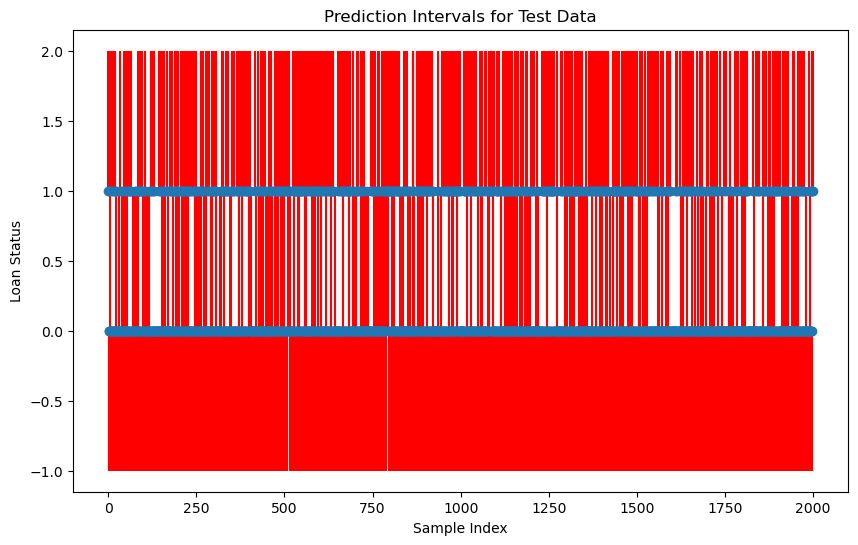

In [35]:
# Generate prediction intervals
prediction_intervals = icp.predict(X_test.values, significance=0.1)

# Plot: Prediction Intervals
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(prediction_intervals)), y_test[:len(prediction_intervals)], 
             yerr=[prediction_intervals[:, 0], prediction_intervals[:, 1]], fmt='o', ecolor='red', capthick=2)
plt.title('Prediction Intervals for Test Data')
plt.xlabel('Sample Index')
plt.ylabel('Loan Status')
plt.show()